In [1]:

import numpy as np
import pandas as pd
import sidetable as stb
from sklearn.preprocessing import RobustScaler
from pandas import get_dummies
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('datos/df_global.csv', index_col=0)

## 1. Estandarizamos las numéricas:

In [3]:
numericas = df.select_dtypes(include=np.number)

In [4]:
numericas

,Duration,Net Sales,Commision (in value),Age
21,12,46.15,11.54,44
22,7,17.55,4.39,25
23,12,94.00,23.50,34
26,29,9.90,5.94,33
27,28,9.90,5.94,33
...,...,...,...,...
63318,10,35.00,12.25,54
63319,10,35.00,12.25,51
63320,5,18.00,6.30,27
63323,2,18.00,6.30,57


In [5]:
robust= RobustScaler()

In [6]:
robust.fit(numericas)

RobustScaler()

In [7]:
X_robust= robust.transform(numericas)


In [8]:
numericas_robust=pd.DataFrame (X_robust, columns=(numericas.columns)+'_Robust')
numericas_robust

,Duration_Robust,Net Sales_Robust,Commision (in value)_Robust,Age_Robust
0,0.000000,0.924312,1.268132,0.727273
1,-0.416667,-0.387615,0.482418,-1.000000
2,0.000000,3.119266,2.582418,-0.181818
3,1.416667,-0.738532,0.652747,-0.272727
4,1.333333,-0.738532,0.652747,-0.272727
...,...,...,...,...
27989,-0.166667,0.412844,1.346154,1.636364
27990,-0.166667,0.412844,1.346154,1.363636
27991,-0.583333,-0.366972,0.692308,-0.818182
27992,-0.833333,-0.366972,0.692308,1.909091


In [9]:
df_global_estandarizado = pd.concat( [df,  numericas_robust], axis=1)

In [10]:
df_global_estandarizado.head(2)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Duration,Destination,Net Sales,Commision (in value),Age,Duration_Robust,Net Sales_Robust,Commision (in value)_Robust,Age_Robust
21,C2B,Airlines,Online,Bronze Plan,No,12.0,SINGAPORE,46.15,11.54,44.0,0.583333,-0.275229,0.0,0.909091
22,C2B,Airlines,Online,Bronze Plan,No,7.0,SINGAPORE,17.55,4.39,25.0,0.500000,0.183486,0.0,0.000000


In [11]:
df_global_estandarizado.drop (numericas.columns, axis=1, inplace=True)

In [12]:
df_global_estandarizado.head(2)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Destination,Duration_Robust,Net Sales_Robust,Commision (in value)_Robust,Age_Robust
21,C2B,Airlines,Online,Bronze Plan,No,SINGAPORE,0.583333,-0.275229,0.0,0.909091
22,C2B,Airlines,Online,Bronze Plan,No,SINGAPORE,0.500000,0.183486,0.0,0.000000


## 2. Codificación de las variables categóricas:

In [13]:
categoricas= df.select_dtypes(include='O')
categoricas.columns

Index(['Agency', 'Agency Type', 'Distribution Channel', 'Product Name',
       'Claim', 'Destination'],
      dtype='object')

In [14]:
categoricas.head(1)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Destination
21,C2B,Airlines,Online,Bronze Plan,No,SINGAPORE


##### Variable: **Product Name**. 
A priori, parece que esta variable no debería tener orden pero se explora mejor.

In [15]:
df['Product Name'].value_counts()

Cancellation Plan                      7854
2 way Comprehensive Plan               5431
Rental Vehicle Excess Insurance        3714
Basic Plan                             3027
Bronze Plan                            2722
1 way Comprehensive Plan               1613
Silver Plan                            1504
Value Plan                             1043
Ticket Protector                        314
Gold Plan                               235
24 Protect                              153
Single Trip Travel Protect Gold         144
Single Trip Travel Protect Silver       121
Premier Plan                             66
Single Trip Travel Protect Platinum      53
Name: Product Name, dtype: int64

In [16]:
len(df['Product Name'].unique())

15

In [17]:
producto = df.stb.freq (['Product Name'], thresh=80 )

In [18]:
producto

,Product Name,count,percent,cumulative_count,cumulative_percent
0,Cancellation Plan,7854,28.056012,7854,28.056012
1,2 way Comprehensive Plan,5431,19.400586,13285,47.456598
2,Rental Vehicle Excess Insurance,3714,13.267129,16999,60.723727
3,Basic Plan,3027,10.813031,20026,71.536758
4,others,7968,28.463242,27994,100.000000


No se le puede dar orden pero al codificarla se generarían 15 columnas adicionales. Son muchas por lo que en una tabla de fercuencias se comprueba que la mayoría de los registros se concentran en 5 tipos de seguros. Lo más operativo para hacer este ejercicio es agrupar el resto bajo la categoria 'otros_productos'.

In [19]:
lista_producto= (producto['Product Name']).to_list()

In [20]:
df['Product Name'] = df['Product Name'].apply(lambda x: 'otros_productos' if x not in lista_producto else x)

In [21]:
df['Product Name'].unique()

array(['otros_productos', 'Rental Vehicle Excess Insurance',
       '2 way Comprehensive Plan', 'Cancellation Plan', 'Basic Plan'],
      dtype=object)

Codificación:


In [22]:
producto_dummies=pd.get_dummies(df['Product Name'], prefix_sep = "_", prefix = "product", dtype = int)

In [23]:
df_producto_dummies = pd.concat([df, producto_dummies], axis = 1)

In [24]:
df_producto_dummies.drop(['Product Name'], axis=1, inplace=True)

##### Variable: **Agency**. 
En teoria, tampoco debería tener orden. Lo vemos.

In [25]:
df['Agency'].value_counts()

EPX    14898
C2B     4461
CWT     3714
JZI     3488
RAB      453
LWC      318
SSI      314
ART      168
KML      157
ADM       23
Name: Agency, dtype: int64

In [26]:
#abrimos el df en el que se ven solo los reclamados
df_claim= pd.read_csv('datos/df_claim.csv', index_col=0)

In [27]:
df_claim['Agency'].value_counts()

C2B    239
EPX     71
CWT     41
JZI     15
LWC     13
KML      6
SSI      2
CCR      2
RAB      1
TST      1
Name: Agency, dtype: int64

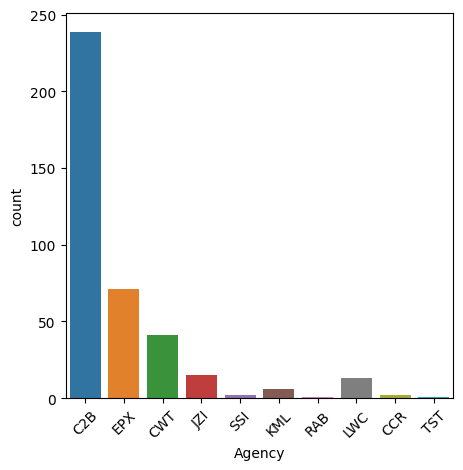

In [28]:
plt.figure (figsize= (5, 5))
sns.countplot (data=df_claim, x='Agency')
plt.xticks( rotation= 45);

 Tras la exploración, se ve que hay una agencia (la segunda en ventas) que es la que más reclamaciones tiene. Llama la atención, quizás pueda tratarse de una mala práctica en la venta o debido al tipo de seguro que vende o incluso a un fraude. Sin embargo, por el momento no se le va a dar orden, ya que no podría responder a ningún criterio objetivo ni subjetivo por el que ordenarlo. 

Se sigue el mismo proceso que se hizo en la variable anterior. Se categoriza bajo la etiqueta 'otras_agencias', aquellas agencias minoritarias (el 2% del total) con el fin de no generar tantas columnas.

In [29]:
agencias  = df.stb.freq (['Agency'], thresh=98)

In [30]:
lista_agencias= (agencias['Agency']).to_list()

In [31]:
df_producto_dummies['Agency'] = df_producto_dummies['Agency'].apply(lambda x: 'otras_agencias' if x not in lista_agencias else x)

In [32]:
df_producto_dummies['Agency'].unique()

array(['C2B', 'CWT', 'EPX', 'RAB', 'otras_agencias', 'JZI', 'LWC'],
      dtype=object)

Se codifica:

In [33]:
producto_agencia_dummies = pd.get_dummies(df_producto_dummies['Agency'], prefix_sep = "_", prefix = "agencia", dtype = int)

In [34]:
df_producto_agencia_dummies = pd.concat([df_producto_dummies, producto_agencia_dummies], axis = 1)

In [35]:
df_producto_agencia_dummies.drop( ['Agency'], axis=1, inplace=True)

##### Variable: **Distribucion Channel**
Se borra esta columna, ya que solo hay un valor para ella. Todas las ventas son online por lo que no aporta nada.

In [36]:
df_producto_agencia_dummies.drop (['Distribution Channel'], axis=1, inplace=True)

##### Variable: **Destination**. 
En principio no tiene orden. 

In [37]:
len(df_producto_agencia_dummies['Destination'].unique())

125

Si la se codifica tal y como está, generaría 125 columnas adicionales. Se categoriza de nuevo. Se eliminan los destinos minoritarios, de manera que solo quedan los que suponen un 80% del total de los registros. Y el resto queda en una misma categría llamada 'otros_destinos'.

In [38]:
destinos = df_producto_agencia_dummies.stb.freq (['Destination'], thresh=80 )

In [39]:
lista_paises = (destinos['Destination']).to_list()

In [40]:
df_producto_agencia_dummies['Destination'] = df_producto_agencia_dummies['Destination'].apply(lambda x: 'otros' if x not in lista_paises else x)


In [41]:
df_producto_agencia_dummies['Destination'].unique()

array(['SINGAPORE', 'UNITED STATES', 'otros', 'AUSTRALIA', 'INDONESIA',
       'MALAYSIA', 'THAILAND', 'CHINA', 'VIET NAM', 'PHILIPPINES',
       'HONG KONG', 'JAPAN'], dtype=object)

In [42]:
dummies_destinos=pd.get_dummies(df_producto_agencia_dummies['Destination'], prefix_sep = "_", prefix = "destination", dtype = int)


In [43]:
df_producto_agencia_destino_dummies = pd.concat([df_producto_agencia_dummies, dummies_destinos], axis = 1)


In [44]:
df_producto_agencia_destino_dummies.drop(['Destination'], inplace=True, axis=1)

##### Variable: **Agency Type**. 
En principio no tiene orden. 

In [45]:
df_producto_agencia_destino_dummies['Agency Type'].unique()

array(['Airlines', 'Travel Agency'], dtype=object)

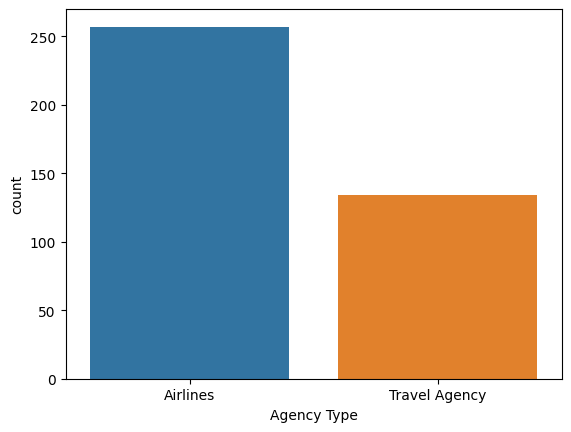

In [46]:
sns.countplot(x='Agency Type' , data= df_claim);

Vemos que hay más reclamaciones a las aerolineas que a las Agencias. Si recordamos, se ha eliminado una columna que se refería al canal de ventas, ya que la gran mayoria de las reclamaciones procedían de la venta online. Por lo tanto, tiene sentido que la mayoría de las reclamaciones sean a Aerolineas, ya que son las que venden exclusivamente online, mientras que las Agencias pueden vender por los dos canales. En conclusión, parece que tiene orden ya que es más probable que se reclame un billete de avion (vendido por aerolinea) que un viaje completo (vendido por agencia).

Se codifica mediante mapeo.

In [47]:
df_producto_agencia_destino_dummies['Agency Type'].unique()

array(['Airlines', 'Travel Agency'], dtype=object)

In [48]:
mapa= {'Travel Agency':0, 'Airlines':1 }

In [49]:
df_producto_agencia_destino_dummies['Agency Type']= df_producto_agencia_destino_dummies['Agency Type'].map(mapa)

In [50]:
df_producto_agencia_destino_dummies['Agency Type'].unique()

array([1, 0], dtype=int64)

#### Variable respuesta: **Claim**

Primero se renombra nuestro df para que sea más sencillo.

In [51]:
df_gral_dumi = df_producto_agencia_destino_dummies.copy()

In [52]:
df_gral_dumi['Claim'].value_counts()

No     27608
Yes      386
Name: Claim, dtype: int64

Se codifica con map porque esta variable sí tiene orden.

In [53]:
mapa1= {'No':0, 'Yes':1 }

In [54]:
df_gral_dumi['Claim']= df_gral_dumi['Claim'].map(mapa1)

In [55]:
df_gral_dumi['Claim'].unique()

array([0, 1], dtype=int64)

In [56]:
df_gral_dumi.head(2)

,Agency Type,Claim,Duration,Net Sales,Commision (in value),Age,product_2 way Comprehensive Plan,product_Basic Plan,product_Cancellation Plan,product_Rental Vehicle Excess Insurance,...,destination_HONG KONG,destination_INDONESIA,destination_JAPAN,destination_MALAYSIA,destination_PHILIPPINES,destination_SINGAPORE,destination_THAILAND,destination_UNITED STATES,destination_VIET NAM,destination_otros
21,1,0,12,46.15,11.54,44,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
22,1,0,7,17.55,4.39,25,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Ya están codificadas todas las categóricas y la variable respuesta.


In [57]:
#guardado
df_gral_dumi. to_csv ('datos/df_codificado_completo.csv')

Se hace una unión con las variables numéricas estandarizadas.

In [58]:
df_estandarizado_codificado =pd.concat ([df_global_estandarizado, df_gral_dumi], axis=1)
df_estandarizado_codificado.head(2)

,Agency,Agency Type,Distribution Channel,Product Name,Claim,Destination,Duration_Robust,Net Sales_Robust,Commision (in value)_Robust,Age_Robust,...,destination_HONG KONG,destination_INDONESIA,destination_JAPAN,destination_MALAYSIA,destination_PHILIPPINES,destination_SINGAPORE,destination_THAILAND,destination_UNITED STATES,destination_VIET NAM,destination_otros
21,C2B,Airlines,Online,Bronze Plan,No,SINGAPORE,0.583333,-0.275229,0.0,0.909091,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22,C2B,Airlines,Online,Bronze Plan,No,SINGAPORE,0.500000,0.183486,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 3. Balanceo de la variable respuesta:

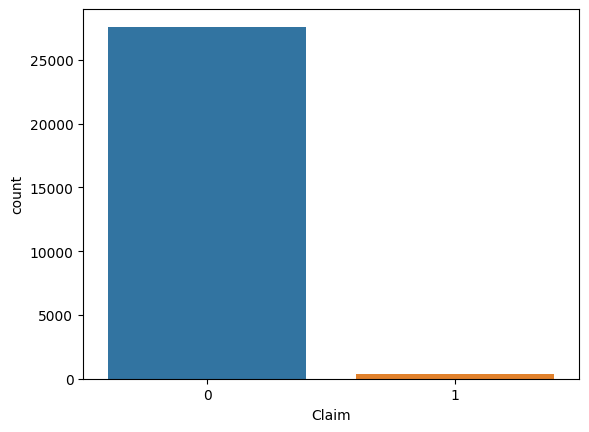

In [59]:
sns.countplot (x='Claim' , data= df_gral_dumi);

La variable respuesta esta muy desequilibrada. Se a balancea haciendo Down Sampling mediante el método SMOTE.

In [60]:
y = df_gral_dumi['Claim']
X = df_gral_dumi.drop('Claim', axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [62]:
smote = SMOTE()

In [63]:
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [64]:
y_train.value_counts()

0    19324
1      271
Name: Claim, dtype: int64

In [65]:
y_train_res.value_counts()

0    19324
1    19324
Name: Claim, dtype: int64

In [66]:
balanceado = pd.concat([X_train_res, y_train_res], axis = 1)
balanceado.head()

,Agency Type,Duration,Net Sales,Commision (in value),Age,product_2 way Comprehensive Plan,product_Basic Plan,product_Cancellation Plan,product_Rental Vehicle Excess Insurance,product_otros_productos,...,destination_INDONESIA,destination_JAPAN,destination_MALAYSIA,destination_PHILIPPINES,destination_SINGAPORE,destination_THAILAND,destination_UNITED STATES,destination_VIET NAM,destination_otros,Claim
0,1,8,37.5,9.38,28,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,1,9,26.0,9.10,51,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,13,26.0,9.10,42,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,19,17.0,4.25,35,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
4,0,6,49.5,29.70,48,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


Comprobación y guardado.

In [67]:
balanceado['Claim'].value_counts()

0    19324
1    19324
Name: Claim, dtype: int64

In [68]:
balanceado.to_csv('datos/df_codificado_balanceado.csv')